# Similarity-Based Information Retrieval

## A Comprehensive Guide to Vector Space Models and Beyond

This notebook provides a hands-on introduction to similarity-based information retrieval, covering:
1. Vector space models
2. Term frequency-inverse document frequency (TF-IDF)
3. Cosine similarity and other distance metrics

## 0. Setup and Dependencies

First, we'll install and import the necessary libraries.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import plotly.express as px
import plotly.graph_objects as go
import math
from IPython.display import display, Markdown, HTML
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 1. Introduction to Information Retrieval

Information Retrieval (IR) is the process of finding material (usually documents) that satisfies an information need from within large collections. Similarity-based IR approaches use various metrics to determine how "close" or "similar" documents are to a query or to each other.

Let's start with a simple example collection of documents:

In [ ]:
# Sample document collection
documents = [
    "Machine learning is a subset of artificial intelligence",
    "Natural language processing deals with interactions between computers and human language",
    "Deep learning uses neural networks with many layers",
    "Information retrieval is finding relevant documents for a query",
    "Machine learning algorithms learn from data",
    "Neural networks are inspired by the human brain",
    "Vector space models represent documents as vectors",
    "TF-IDF weighs terms based on their frequency and uniqueness",
    "Cosine similarity measures the angle between vectors",
    "Dimensionality reduction techniques compress vector representations"
]

# Assign document IDs
doc_ids = [f"doc_{i}" for i in range(len(documents))]
corpus = dict(zip(doc_ids, documents))

print("Document Collection:")
for doc_id, content in corpus.items():
    print(f"{doc_id}: {content}")

Document Collection:
doc_0: Machine learning is a subset of artificial intelligence
doc_1: Natural language processing deals with interactions between computers and human language
doc_2: Deep learning uses neural networks with many layers
doc_3: Information retrieval is finding relevant documents for a query
doc_4: Machine learning algorithms learn from data
doc_5: Neural networks are inspired by the human brain
doc_6: Vector space models represent documents as vectors
doc_7: TF-IDF weighs terms based on their frequency and uniqueness
doc_8: Cosine similarity measures the angle between vectors
doc_9: Dimensionality reduction techniques compress vector representations


## 2. Text Preprocessing

Before computing similarities, we need to preprocess the text data. This typically includes:
- Converting to lowercase
- Removing punctuation and special characters
- Tokenization (splitting text into words)
- Removing stopwords (common words like "the", "and", etc.)
- Stemming or lemmatization (reducing words to their root form)

Let's implement a preprocessing pipeline:

In [ ]:
def preprocess_text(text, remove_stopwords=True, stemming=False, lemmatization=True):
    """
    Preprocess text by performing the following operations:
    1. Convert to lowercase
    2. Remove special characters and numbers
    3. Tokenize
    4. Remove stopwords (optional)
    5. Apply stemming or lemmatization (optional)

    Args:
        text: Input text to preprocess
        remove_stopwords: Whether to remove stopwords
        stemming: Whether to apply stemming
        lemmatization: Whether to apply lemmatization

    Returns:
        processed_text: Preprocessed text as a string of tokens
    """
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

    # Apply stemming
    if stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    # Apply lemmatization
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a string
    processed_text = ' '.join(tokens)

    return processed_text

# Preprocess the document collection
preprocessed_corpus = {doc_id: preprocess_text(text) for doc_id, text in corpus.items()}

print("Preprocessed Document Collection:")
for doc_id, content in preprocessed_corpus.items():
    print(f"{doc_id}: {content}")

Preprocessed Document Collection:
doc_0: machine learning subset artificial intelligence
doc_1: natural language processing deal interaction computer human language
doc_2: deep learning us neural network many layer
doc_3: information retrieval finding relevant document query
doc_4: machine learning algorithm learn data
doc_5: neural network inspired human brain
doc_6: vector space model represent document vector
doc_7: tfidf weighs term based frequency uniqueness
doc_8: cosine similarity measure angle vector
doc_9: dimensionality reduction technique compress vector representation


Let's explore how preprocessing affects our documents:

In [ ]:
# Display original vs preprocessed text
comparison_df = pd.DataFrame({
    'Original': list(corpus.values()),
    'Preprocessed': list(preprocessed_corpus.values())
})

display(comparison_df)

,Original,Preprocessed
0,Machine learning is a subset of artificial int...,machine learning subset artificial intelligence
1,Natural language processing deals with interac...,natural language processing deal interaction c...
2,Deep learning uses neural networks with many l...,deep learning us neural network many layer
3,Information retrieval is finding relevant docu...,information retrieval finding relevant documen...
4,Machine learning algorithms learn from data,machine learning algorithm learn data
5,Neural networks are inspired by the human brain,neural network inspired human brain
6,Vector space models represent documents as vec...,vector space model represent document vector
7,TF-IDF weighs terms based on their frequency a...,tfidf weighs term based frequency uniqueness
8,Cosine similarity measures the angle between v...,cosine similarity measure angle vector
9,Dimensionality reduction techniques compress v...,dimensionality reduction technique compress ve...


## 3. Vector Space Model

The Vector Space Model (VSM) represents documents as vectors in a high-dimensional space, where each dimension corresponds to a term in the vocabulary.

### Count Vectorizer (Binary)

Binary Document-Term Matrix:


,algorithm,angle,artificial,based,brain,compress,computer,cosine,data,deal,...,similarity,space,subset,technique,term,tfidf,uniqueness,us,vector,weighs
doc_0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
doc_1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
doc_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
doc_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
doc_5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_6,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
doc_7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,1
doc_8,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
doc_9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


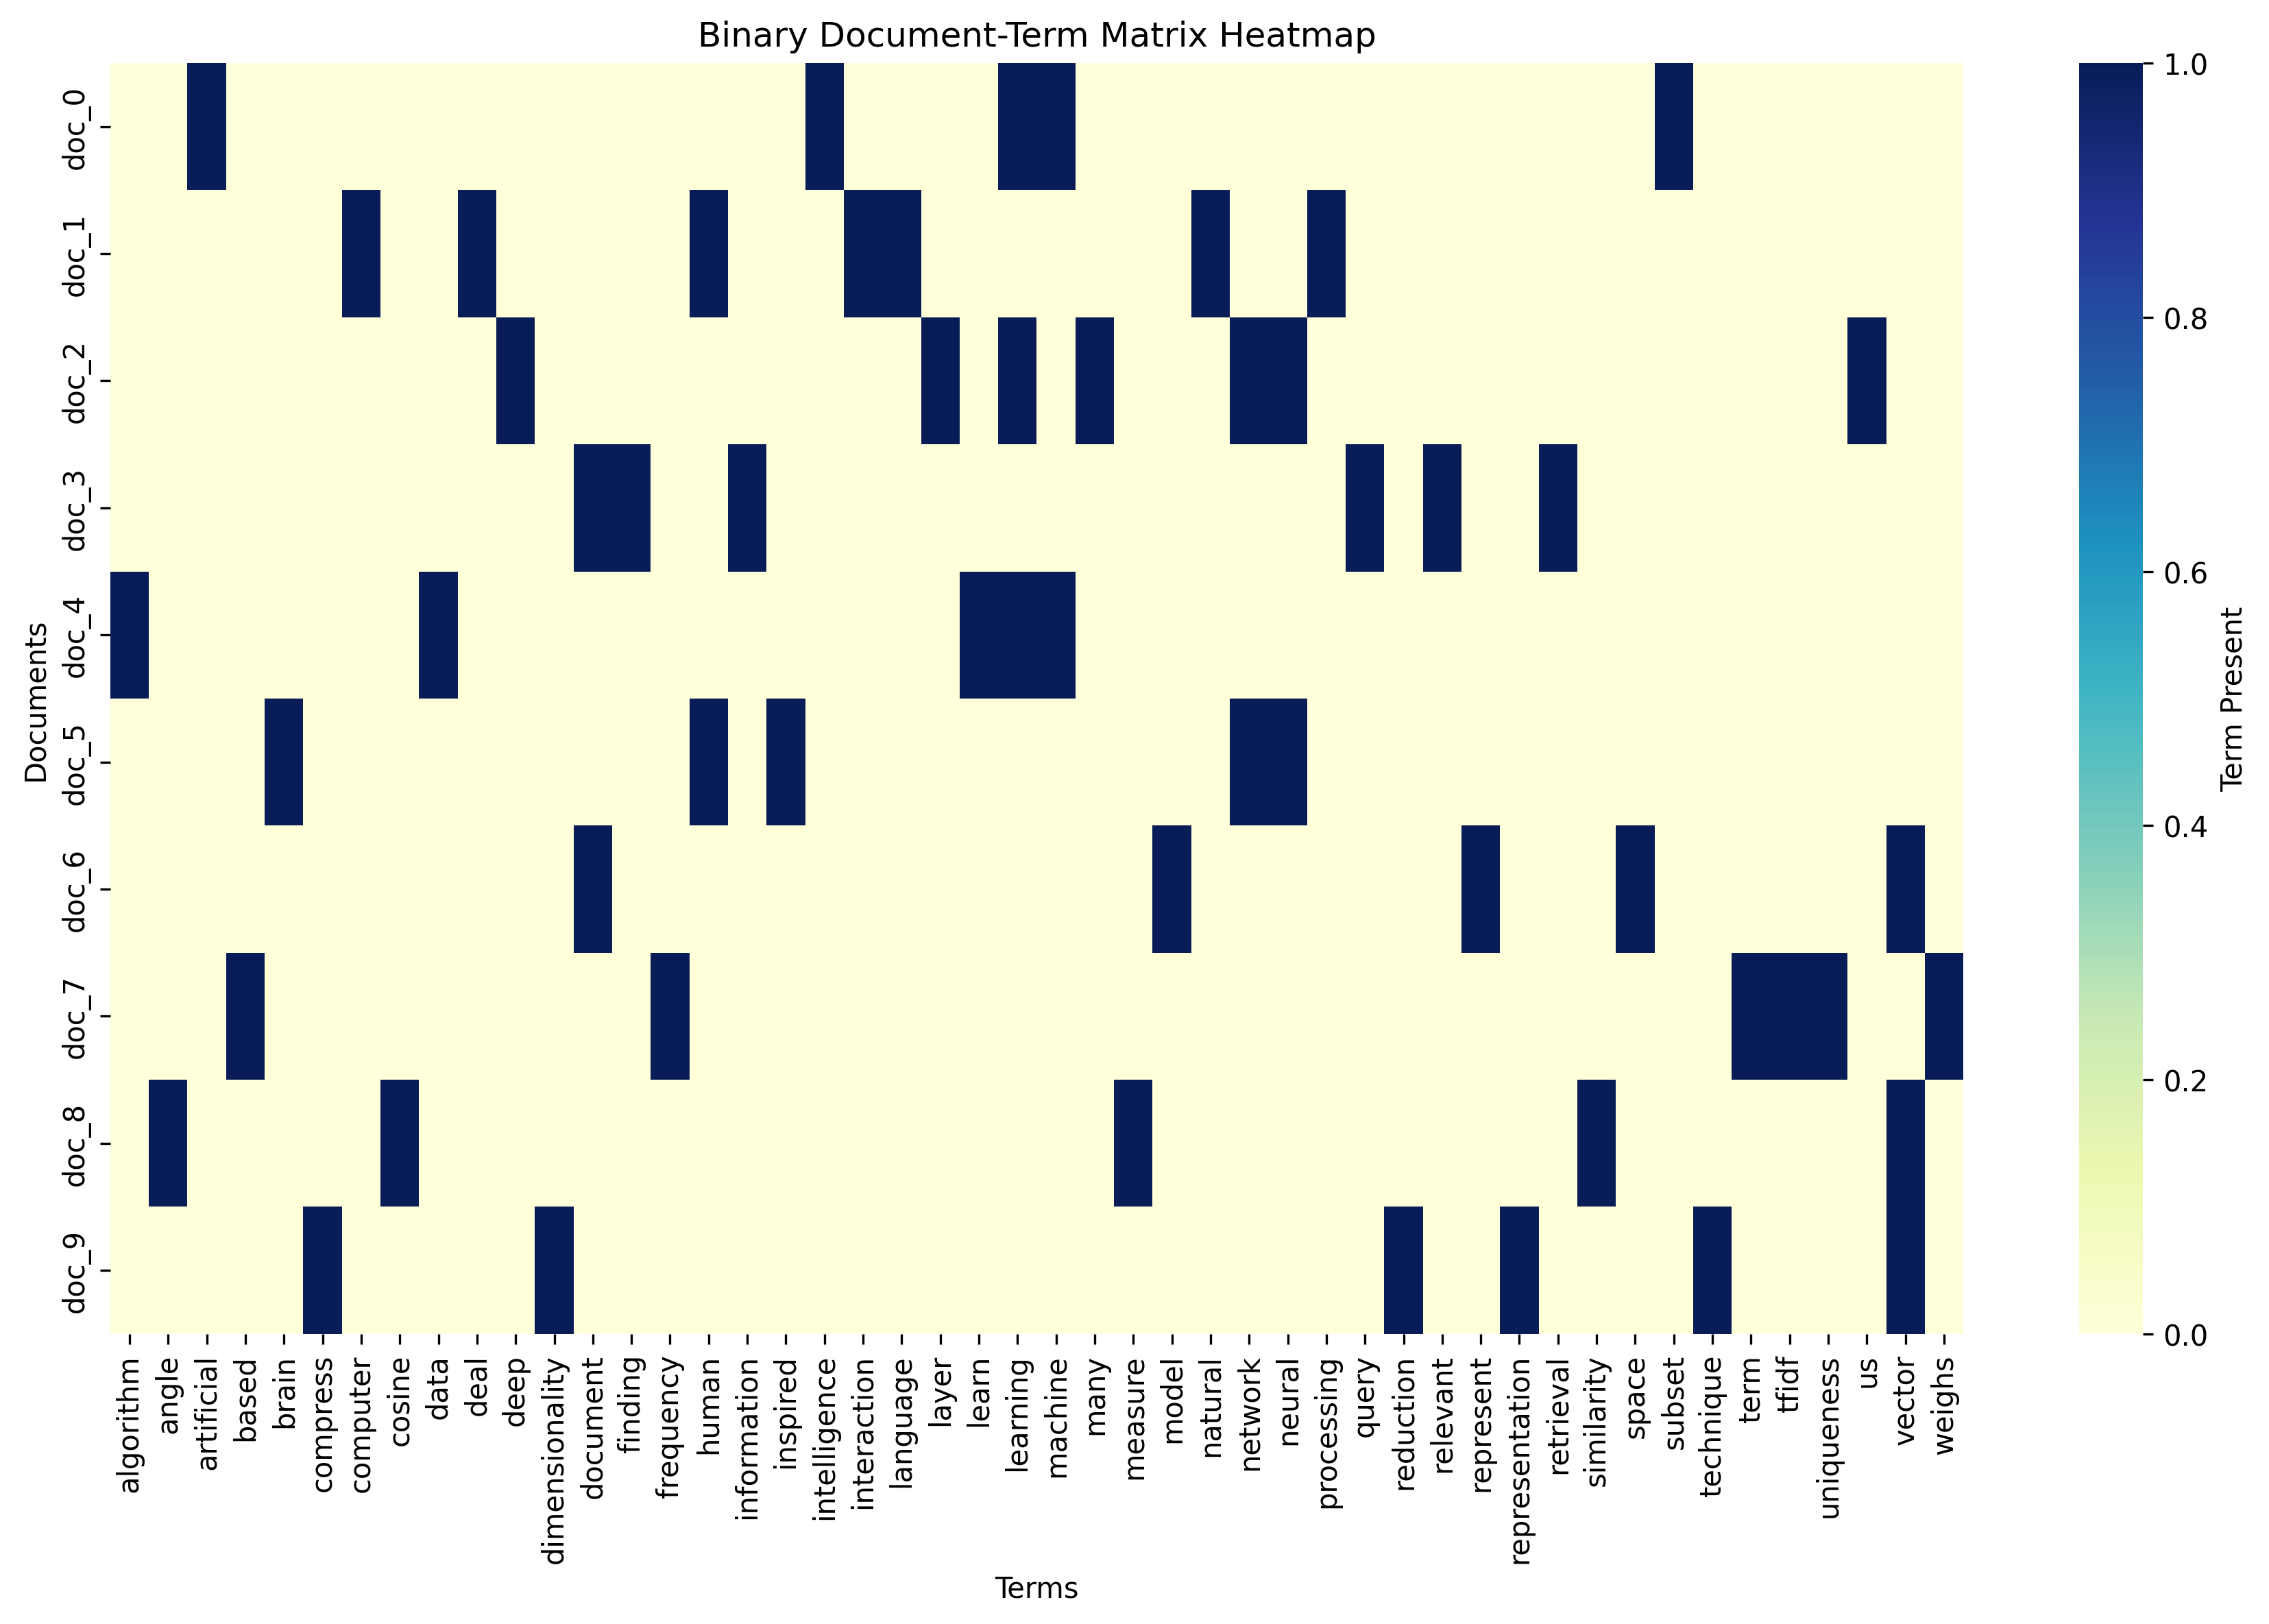

In [ ]:
# Create a CountVectorizer
count_vectorizer = CountVectorizer(binary=True)
X_binary = count_vectorizer.fit_transform([preprocessed_corpus[doc_id] for doc_id in doc_ids])

# Get the feature names (vocabulary)
feature_names = count_vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
binary_df = pd.DataFrame(X_binary.toarray(), index=doc_ids, columns=feature_names)

print("Binary Document-Term Matrix:")
display(binary_df)

# Visualize the document-term matrix as a heatmap
plt.figure(figsize=(12, 8),dpi=300)
sns.heatmap(binary_df, cmap="YlGnBu", cbar_kws={'label': 'Term Present'})
plt.title("Binary Document-Term Matrix Heatmap")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Term Frequency (TF)

Term Frequency (TF) represents how often a term appears in a document. It's calculated as:

$$TF(t, d) = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}}$$

Let's implement the TF model:

Term Frequency Document-Term Matrix:


,algorithm,angle,artificial,based,brain,compress,computer,cosine,data,deal,...,similarity,space,subset,technique,term,tfidf,uniqueness,us,vector,weighs
doc_0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
doc_1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
doc_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
doc_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
doc_5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_6,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,0
doc_7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,1
doc_8,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
doc_9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


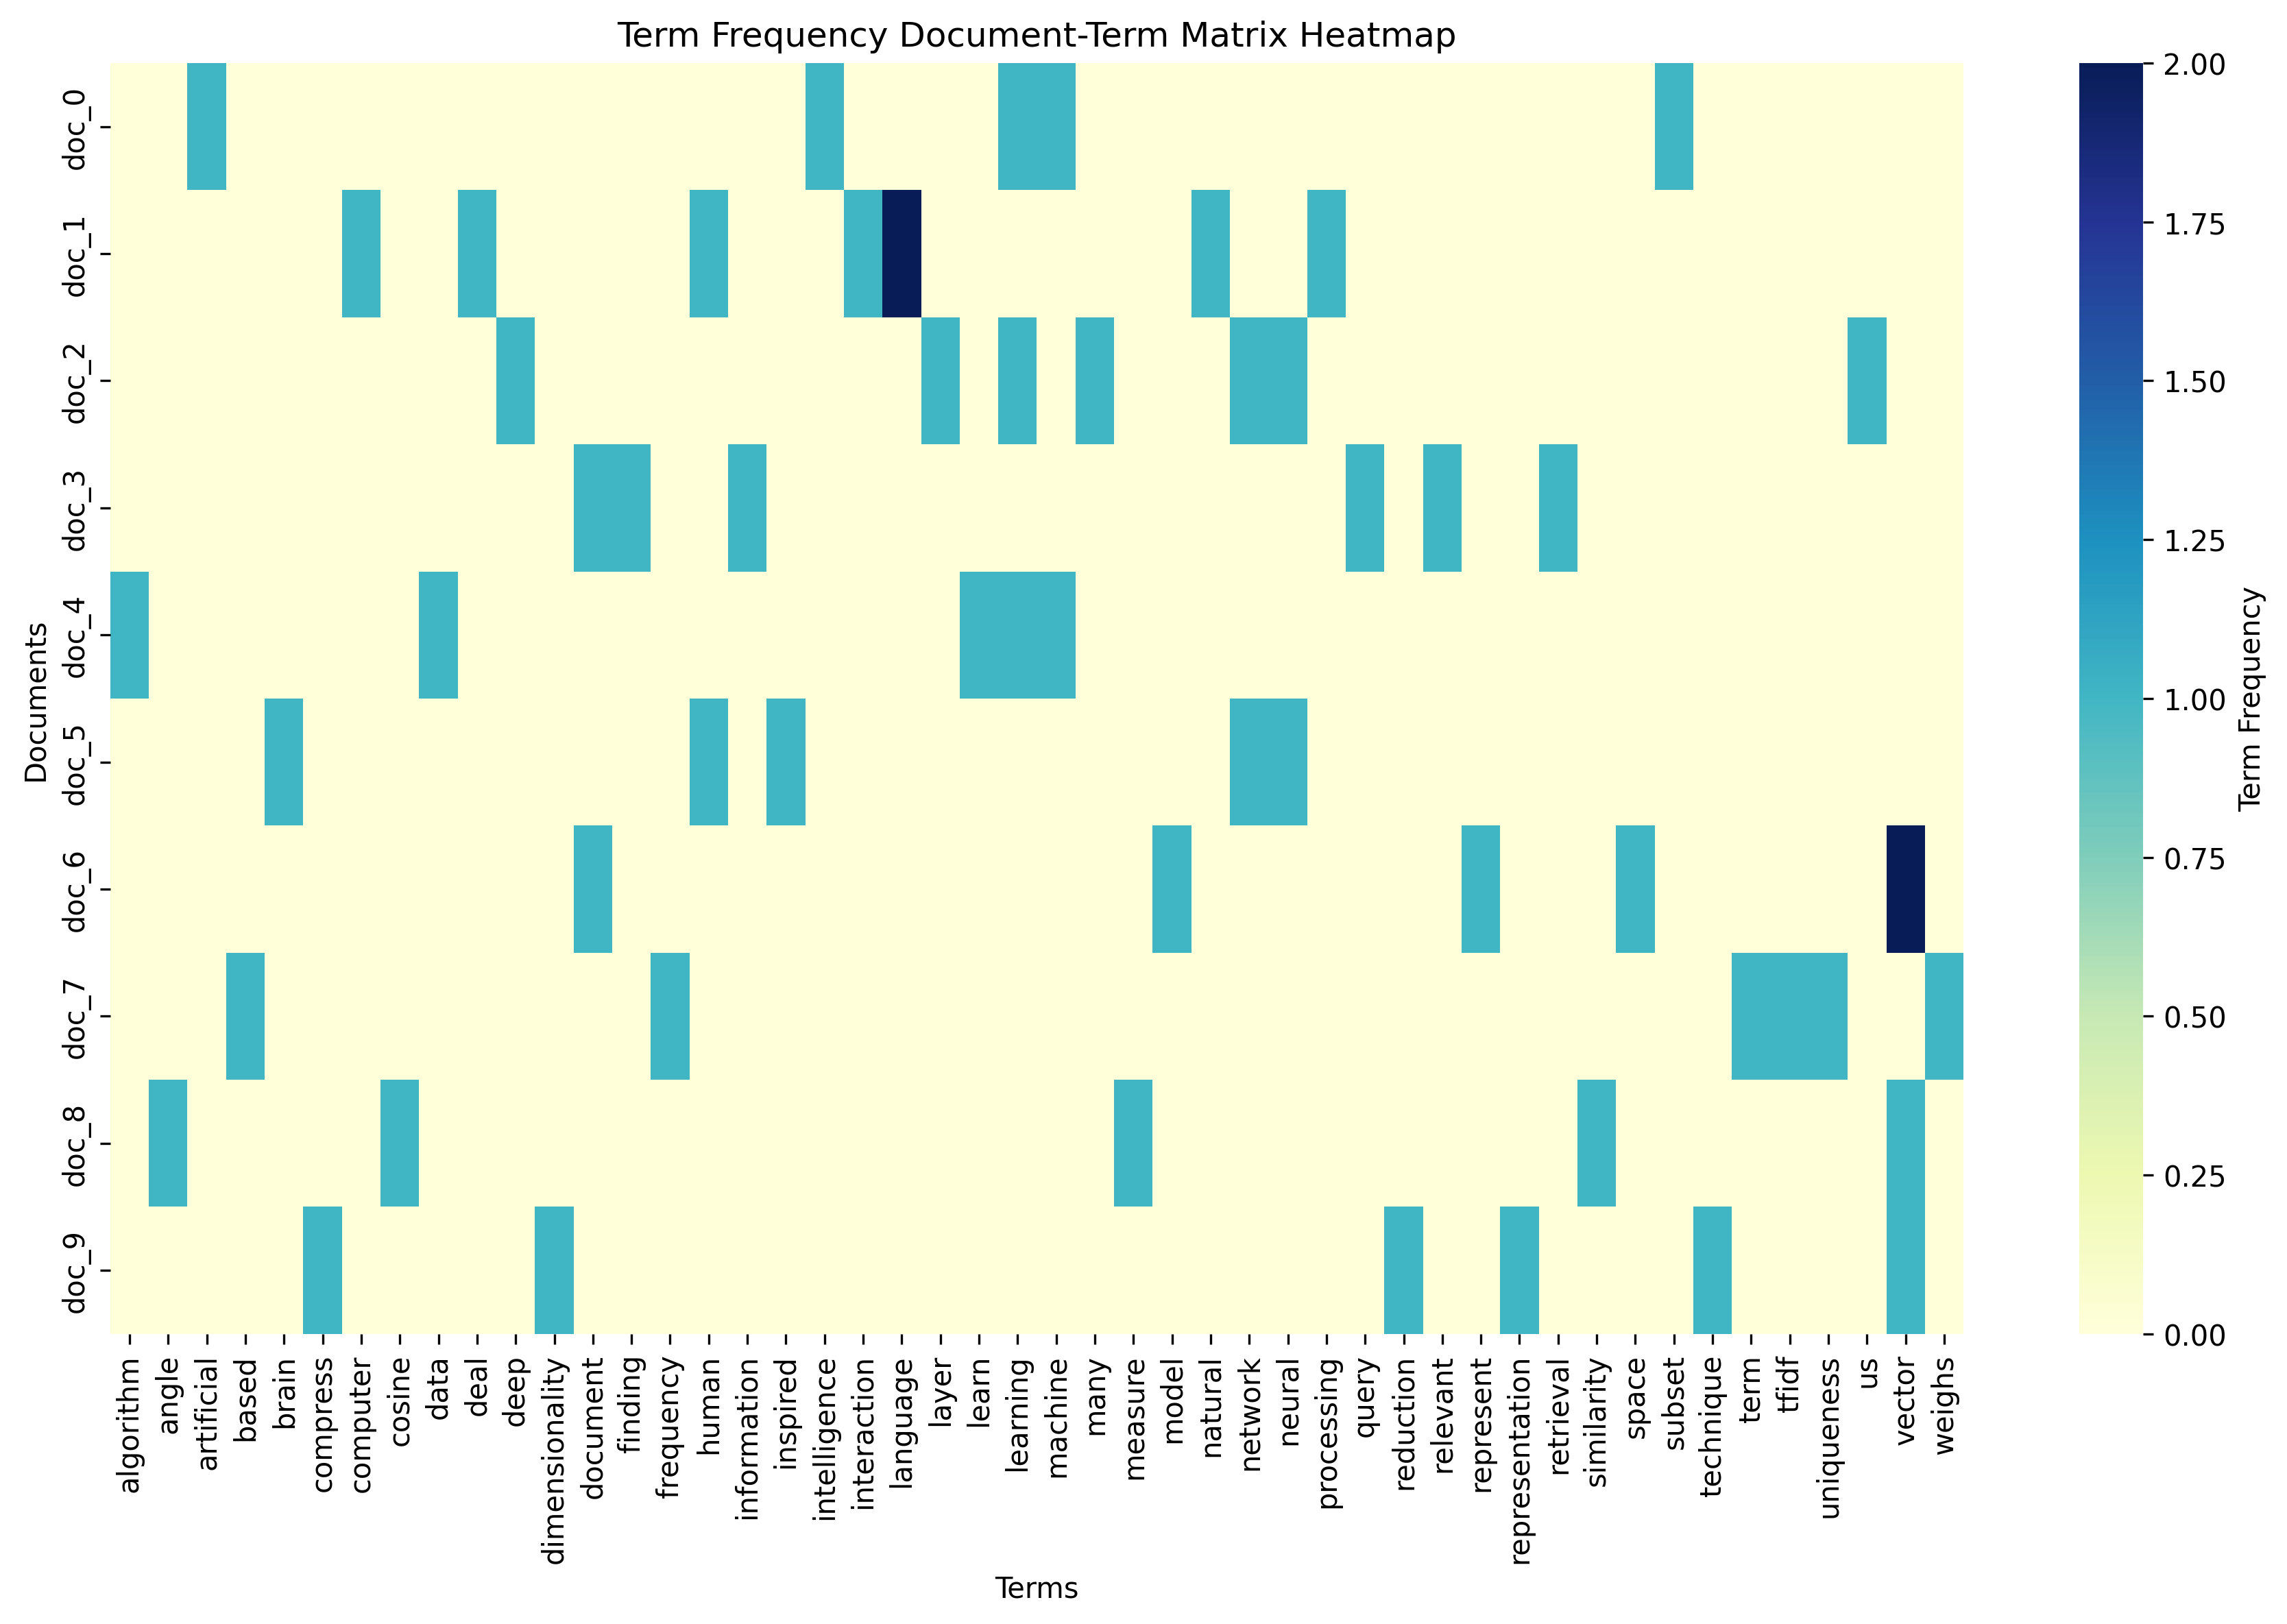

In [ ]:
# Create a CountVectorizer for term frequency
count_vectorizer = CountVectorizer(binary=False)
X_tf = count_vectorizer.fit_transform([preprocessed_corpus[doc_id] for doc_id in doc_ids])

# Get the feature names (vocabulary)
feature_names = count_vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
tf_df = pd.DataFrame(X_tf.toarray(), index=doc_ids, columns=feature_names)

print("Term Frequency Document-Term Matrix:")
display(tf_df)

# Visualize the term frequency document-term matrix as a heatmap
plt.figure(figsize=(12, 8),dpi=300)
sns.heatmap(tf_df, cmap="YlGnBu", cbar_kws={'label': 'Term Frequency'})
plt.title("Term Frequency Document-Term Matrix Heatmap")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Term Frequency-Inverse Document Frequency (TF-IDF)

TF-IDF weighs terms based on their frequency in a document and their uniqueness across the corpus. It's calculated as:

$$TF\text{-}IDF(t, d, D) = TF(t, d) \times IDF(t, D)$$

where:
$$IDF(t, D) = \log\frac{N}{|\{d \in D: t \in d\}|}$$

- N: total number of documents
- |{d ∈ D: t ∈ d}|: number of documents containing term t

Let's implement the TF-IDF model:

TF-IDF Document-Term Matrix:


,algorithm,angle,artificial,based,brain,compress,computer,cosine,data,deal,...,similarity,space,subset,technique,term,tfidf,uniqueness,us,vector,weighs
doc_0,0.000000,0.000000,0.483606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.483606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doc_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320706,0.000000,0.000000,0.320706,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doc_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.408301,0.000000,0.000000
doc_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doc_4,0.483606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.483606,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doc_5,0.000000,0.000000,0.000000,0.000000,0.489822,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doc_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.410471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.610559,0.000000
doc_7,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.408248,0.408248,0.408248,0.000000,0.000000,0.408248
doc_8,0.000000,0.468646,0.000000,0.000000,0.000000,0.000000,0.000000,0.468646,0.000000,0.000000,...,0.468646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348546,0.000000
doc_9,0.000000,0.000000,0.000000,0.000000,0.000000,0.424357,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.424357,0.000000,0.000000,0.000000,0.000000,0.315607,0.000000


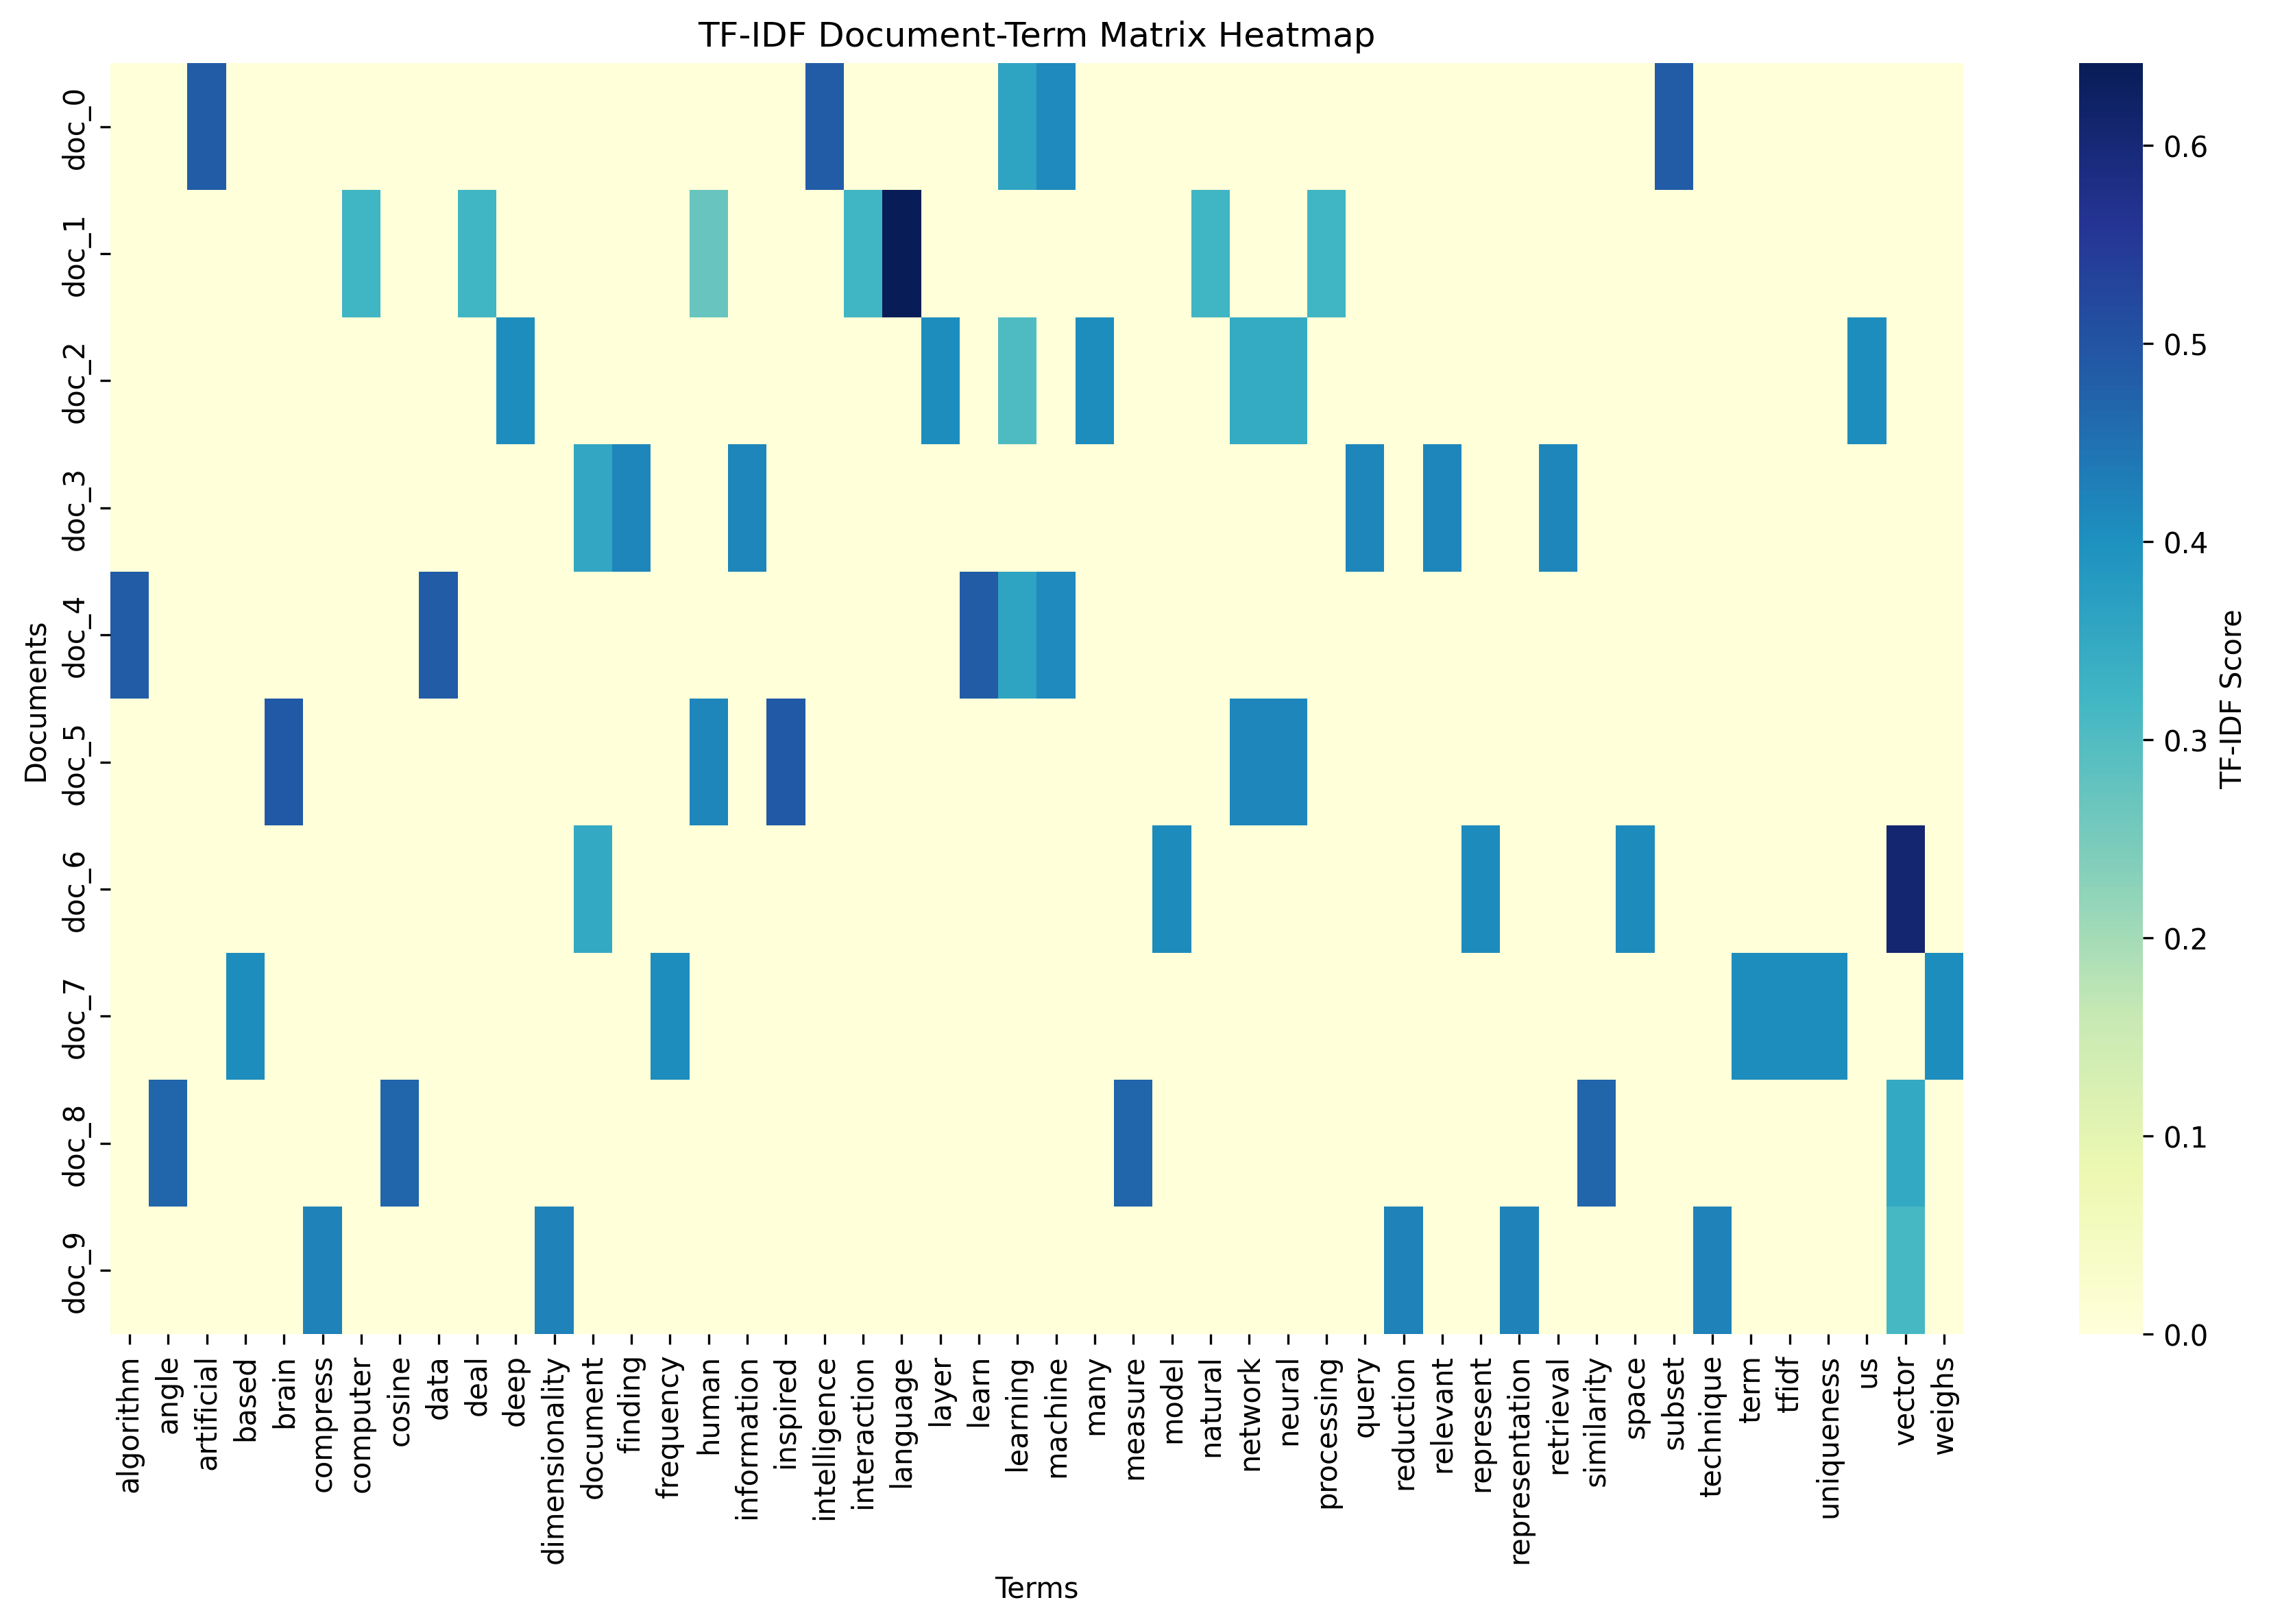

In [ ]:
# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform([preprocessed_corpus[doc_id] for doc_id in doc_ids])

# Get the feature names (vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
tfidf_df = pd.DataFrame(X_tfidf.toarray(), index=doc_ids, columns=feature_names)

print("TF-IDF Document-Term Matrix:")
display(tfidf_df)

# Visualize the TF-IDF document-term matrix as a heatmap
plt.figure(figsize=(12, 8),dpi=300)
sns.heatmap(tfidf_df, cmap="YlGnBu", cbar_kws={'label': 'TF-IDF Score'})
plt.title("TF-IDF Document-Term Matrix Heatmap")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Let's understand TF-IDF with an example:

In [ ]:
# Function to explain TF-IDF calculation for a specific term in a document
def explain_tfidf(term, doc_id, corpus, vectorizer):
    """
    Explain the TF-IDF calculation for a specific term in a document.

    Args:
        term: The term to explain
        doc_id: The document ID
        corpus: The document corpus dictionary
        vectorizer: The fitted TfidfVectorizer
    """
    # Get the document text
    doc_text = preprocessed_corpus[doc_id]

    # Check if the term exists in the vocabulary
    if term not in vectorizer.get_feature_names_out():
        return f"Term '{term}' not found in the vocabulary."

    # Get the term index
    term_idx = np.where(vectorizer.get_feature_names_out() == term)[0][0]

    # Get TF-IDF value
    tfidf_value = X_tfidf.toarray()[doc_ids.index(doc_id), term_idx]

    # Calculate term frequency
    tokens = doc_text.split()
    term_count = tokens.count(term)
    total_terms = len(tokens)
    tf = term_count / total_terms if total_terms > 0 else 0

    # Calculate document frequency
    doc_count = sum(1 for doc in preprocessed_corpus.values() if term in doc.split())

    # Calculate IDF
    N = len(corpus)
    idf = np.log(N / (1 + doc_count)) + 1  # The +1 is a smoothing term used by sklearn

    # Calculate TF-IDF manually
    manual_tfidf = tf * idf

    # Prepare the explanation
    explanation = f"""
    ## TF-IDF Calculation for term '{term}' in document '{doc_id}'

    ### Original Document
    "{corpus[doc_id]}"

    ### Preprocessed Document
    "{doc_text}"

    ### Term Frequency (TF)
    Number of occurrences of '{term}': {term_count}
    Total number of terms in document: {total_terms}
    TF = {term_count} / {total_terms} = {tf:.4f}

    ### Inverse Document Frequency (IDF)
    Number of documents containing '{term}': {doc_count}
    Total number of documents: {N}
    IDF = log({N} / {doc_count}) + 1 = {idf:.4f}

    ### TF-IDF
    TF-IDF = TF × IDF = {tf:.4f} × {idf:.4f} = {manual_tfidf:.4f}

    ### Actual TF-IDF value from sklearn: {tfidf_value:.4f}
    (Note: Slight differences may occur due to normalization and smoothing in sklearn's implementation)
    """

    return explanation

# Example explanation for a specific term and document
term_to_explain = "machine"
doc_to_explain = "doc_0"

explanation = explain_tfidf(term_to_explain, doc_to_explain, corpus, tfidf_vectorizer)
display(Markdown(explanation))


    ## TF-IDF Calculation for term 'machine' in document 'doc_0'

    ### Original Document
    "Machine learning is a subset of artificial intelligence"

    ### Preprocessed Document
    "machine learning subset artificial intelligence"

    ### Term Frequency (TF)
    Number of occurrences of 'machine': 1
    Total number of terms in document: 5
    TF = 1 / 5 = 0.2000

    ### Inverse Document Frequency (IDF)
    Number of documents containing 'machine': 2
    Total number of documents: 10
    IDF = log(10 / 2) + 1 = 2.2040

    ### TF-IDF
    TF-IDF = TF × IDF = 0.2000 × 2.2040 = 0.4408

    ### Actual TF-IDF value from sklearn: 0.4111
    (Note: Slight differences may occur due to normalization and smoothing in sklearn's implementation)
    

## Similarity Metrics

Once we have vector representations of documents, we can compute similarities between them. Let's explore various similarity and distance metrics.

### Cosine Similarity

Cosine similarity measures the cosine of the angle between two vectors. It's calculated as:

$$\text{cosine similarity}(A, B) = \frac{A \cdot B}{||A|| \times ||B||} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \times \sqrt{\sum_{i=1}^{n} B_i^2}}$$


Cosine Similarity Matrix:


,doc_0,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9
doc_0,1.000000,0.000000,0.109220,0.000000,0.298375,0.000000,0.000000,0.0,0.000000,0.000000
doc_1,0.000000,1.000000,0.000000,0.000000,0.000000,0.113521,0.000000,0.0,0.000000,0.000000
doc_2,0.109220,0.000000,1.000000,0.000000,0.109220,0.289055,0.000000,0.0,0.000000,0.000000
doc_3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.123998,0.0,0.000000,0.000000
doc_4,0.298375,0.000000,0.109220,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
doc_5,0.000000,0.113521,0.289055,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
doc_6,0.000000,0.000000,0.000000,0.123998,0.000000,0.000000,1.000000,0.0,0.212808,0.192696
doc_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
doc_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.212808,0.0,1.000000,0.110003
doc_9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192696,0.0,0.110003,1.000000


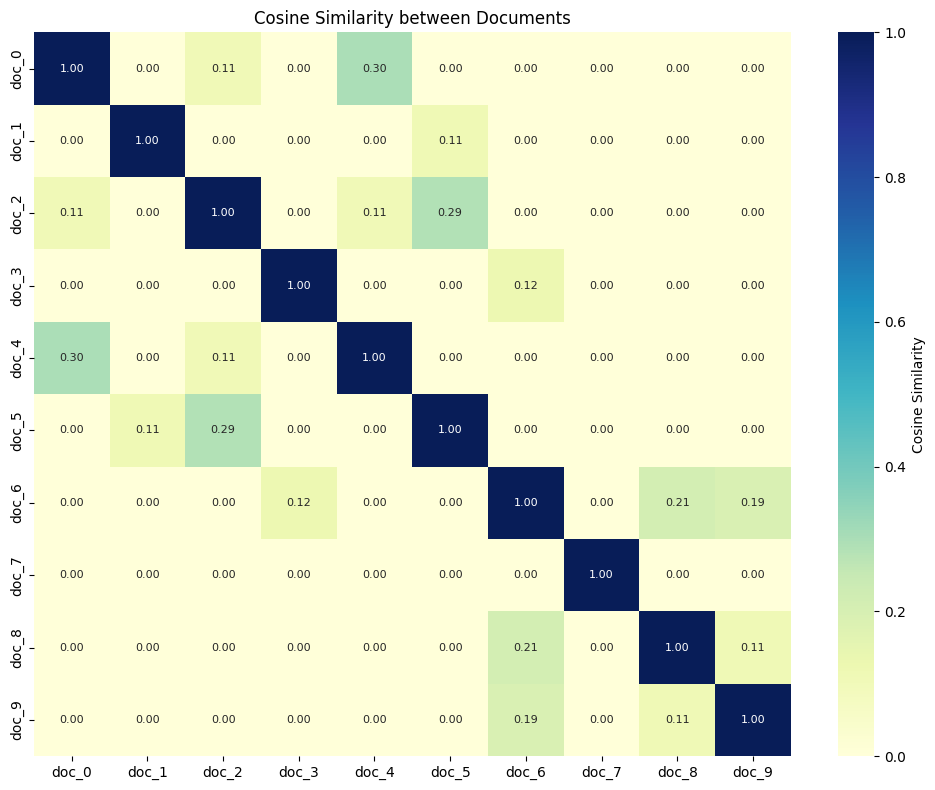

In [ ]:
# Compute cosine similarity between documents using TF-IDF vectors
cosine_sim = cosine_similarity(X_tfidf)

# Create a DataFrame for better visualization
cosine_sim_df = pd.DataFrame(cosine_sim, index=doc_ids, columns=doc_ids)

print("Cosine Similarity Matrix:")
display(cosine_sim_df)

# Visualize the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_df, annot=True, cmap="YlGnBu", vmin=0, vmax=1,
            annot_kws={"size": 8}, fmt=".2f", cbar_kws={'label': 'Cosine Similarity'})
plt.title("Cosine Similarity between Documents")
plt.tight_layout()
plt.show()

# Function to explain cosine similarity calculation between two documents
def explain_cosine_similarity(doc_id1, doc_id2, tfidf_matrix, feature_names):
    """
    Explain the cosine similarity calculation between two documents.

    Args:
        doc_id1: First document ID
        doc_id2: Second document ID
        tfidf_matrix: TF-IDF matrix
        feature_names: Feature names (vocabulary)
    """
    # Get document indices
    doc_idx1 = doc_ids.index(doc_id1)
    doc_idx2 = doc_ids.index(doc_id2)

    # Get document vectors
    vec1 = tfidf_matrix[doc_idx1].toarray().flatten()
    vec2 = tfidf_matrix[doc_idx2].toarray().flatten()

    # Calculate dot product
    dot_product = np.dot(vec1, vec2)

    # Calculate magnitudes
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)

    # Calculate cosine similarity
    cos_sim = dot_product / (magnitude1 * magnitude2) if magnitude1 * magnitude2 != 0 else 0

    # Create contribution table
    contributions = []
    for i, term in enumerate(feature_names):
        if vec1[i] > 0 or vec2[i] > 0:  # Only include terms that appear in at least one document
            contribution = vec1[i] * vec2[i]
            contributions.append((term, vec1[i], vec2[i], contribution))

    # Sort contributions by absolute value
    contributions.sort(key=lambda x: abs(x[3]), reverse=True)

    # Create explanation
    explanation = f"""
    ## Cosine Similarity Calculation between '{doc_id1}' and '{doc_id2}'

    ### Original Documents
    - {doc_id1}: "{corpus[doc_id1]}"
    - {doc_id2}: "{corpus[doc_id2]}"

    ### Vector Representations (TF-IDF)
    The TF-IDF vectors for both documents are shown below (only non-zero values):

    | Term | {doc_id1} | {doc_id2} | Product |
    |------|-----------|-----------|---------|
    """

    for term, val1, val2, prod in contributions:
        if val1 > 0 or val2 > 0:  # Only include terms that appear in at least one document
            explanation += f"| {term} | {val1:.4f} | {val2:.4f} | {prod:.4f} |\n"

    explanation += f"""

    ### Calculation
    Dot product = {dot_product:.4f}
    Magnitude of {doc_id1} = {magnitude1:.4f}
    Magnitude of {doc_id2} = {magnitude2:.4f}

    Cosine similarity = Dot product / (Magnitude1 × Magnitude2)
                      = {dot_product:.4f} / ({magnitude1:.4f} × {magnitude2:.4f})
                      = {dot_product:.4f} / {magnitude1 * magnitude2:.4f}
                      = {cos_sim:.4f}

    ### Interpretation
    - A cosine similarity of 1 means the documents are identical in direction
    - A cosine similarity of 0 means the documents are orthogonal (no similarity)
    - A cosine similarity of -1 means the documents are opposite

    The cosine similarity between '{doc_id1}' and '{doc_id2}' is {cos_sim:.4f}, indicating
    {'high similarity' if cos_sim > 0.7 else 'moderate similarity' if cos_sim > 0.3 else 'low similarity'}.
    """

    return explanation

In [ ]:
# Example explanation for cosine similarity between two documents
doc_id1 = "doc_0"  # "Machine learning is a subset of artificial intelligence"
doc_id2 = "doc_4"  # "Machine learning algorithms learn from data"

explanation = explain_cosine_similarity(doc_id1, doc_id2, X_tfidf, feature_names)
display(Markdown(explanation))


    ## Cosine Similarity Calculation between 'doc_0' and 'doc_4'

    ### Original Documents
    - doc_0: "Machine learning is a subset of artificial intelligence"
    - doc_4: "Machine learning algorithms learn from data"

    ### Vector Representations (TF-IDF)
    The TF-IDF vectors for both documents are shown below (only non-zero values):

    | Term | doc_0 | doc_4 | Product |
    |------|-----------|-----------|---------|
    | machine | 0.4111 | 0.4111 | 0.1690 |
| learning | 0.3597 | 0.3597 | 0.1294 |
| algorithm | 0.0000 | 0.4836 | 0.0000 |
| artificial | 0.4836 | 0.0000 | 0.0000 |
| data | 0.0000 | 0.4836 | 0.0000 |
| intelligence | 0.4836 | 0.0000 | 0.0000 |
| learn | 0.0000 | 0.4836 | 0.0000 |
| subset | 0.4836 | 0.0000 | 0.0000 |


    ### Calculation
    Dot product = 0.2984
    Magnitude of doc_0 = 1.0000
    Magnitude of doc_4 = 1.0000

    Cosine similarity = Dot product / (Magnitude1 × Magnitude2)
                      = 0.2984 / (1.0000 × 1.0000)
                      = 0.2984 / 1.0000
                      = 0.2984

    ### Interpretation
    - A cosine similarity of 1 means the documents are identical in direction
    - A cosine similarity of 0 means the documents are orthogonal (no similarity)
    - A cosine similarity of -1 means the documents are opposite

    The cosine similarity between 'doc_0' and 'doc_4' is 0.2984, indicating
    low similarity.
    

Euclidean distance measures the straight-line distance between two points in Euclidean space. It's calculated as:

$$\text{euclidean distance}(A, B) = \sqrt{\sum_{i=1}^{n} (A_i - B_i)^2}$$


Euclidean Distance Matrix:


,doc_0,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9
doc_0,0.000000,1.414214,1.334751,1.414214,1.184588,1.414214,1.414214,1.414214,1.414214,1.414214
doc_1,1.414214,0.000000,1.414214,1.414214,1.414214,1.331525,1.414214,1.414214,1.414214,1.414214
doc_2,1.334751,1.414214,0.000000,1.414214,1.334751,1.192431,1.414214,1.414214,1.414214,1.414214
doc_3,1.414214,1.414214,1.414214,0.000000,1.414214,1.414214,1.323633,1.414214,1.414214,1.414214
doc_4,1.184588,1.414214,1.334751,1.414214,0.000000,1.414214,1.414214,1.414214,1.414214,1.414214
doc_5,1.414214,1.331525,1.192431,1.414214,1.414214,0.000000,1.414214,1.414214,1.414214,1.414214
doc_6,1.414214,1.414214,1.414214,1.323633,1.414214,1.414214,0.000000,1.414214,1.254745,1.270672
doc_7,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,0.000000,1.414214,1.414214
doc_8,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.254745,1.414214,0.000000,1.334164
doc_9,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.270672,1.414214,1.334164,0.000000


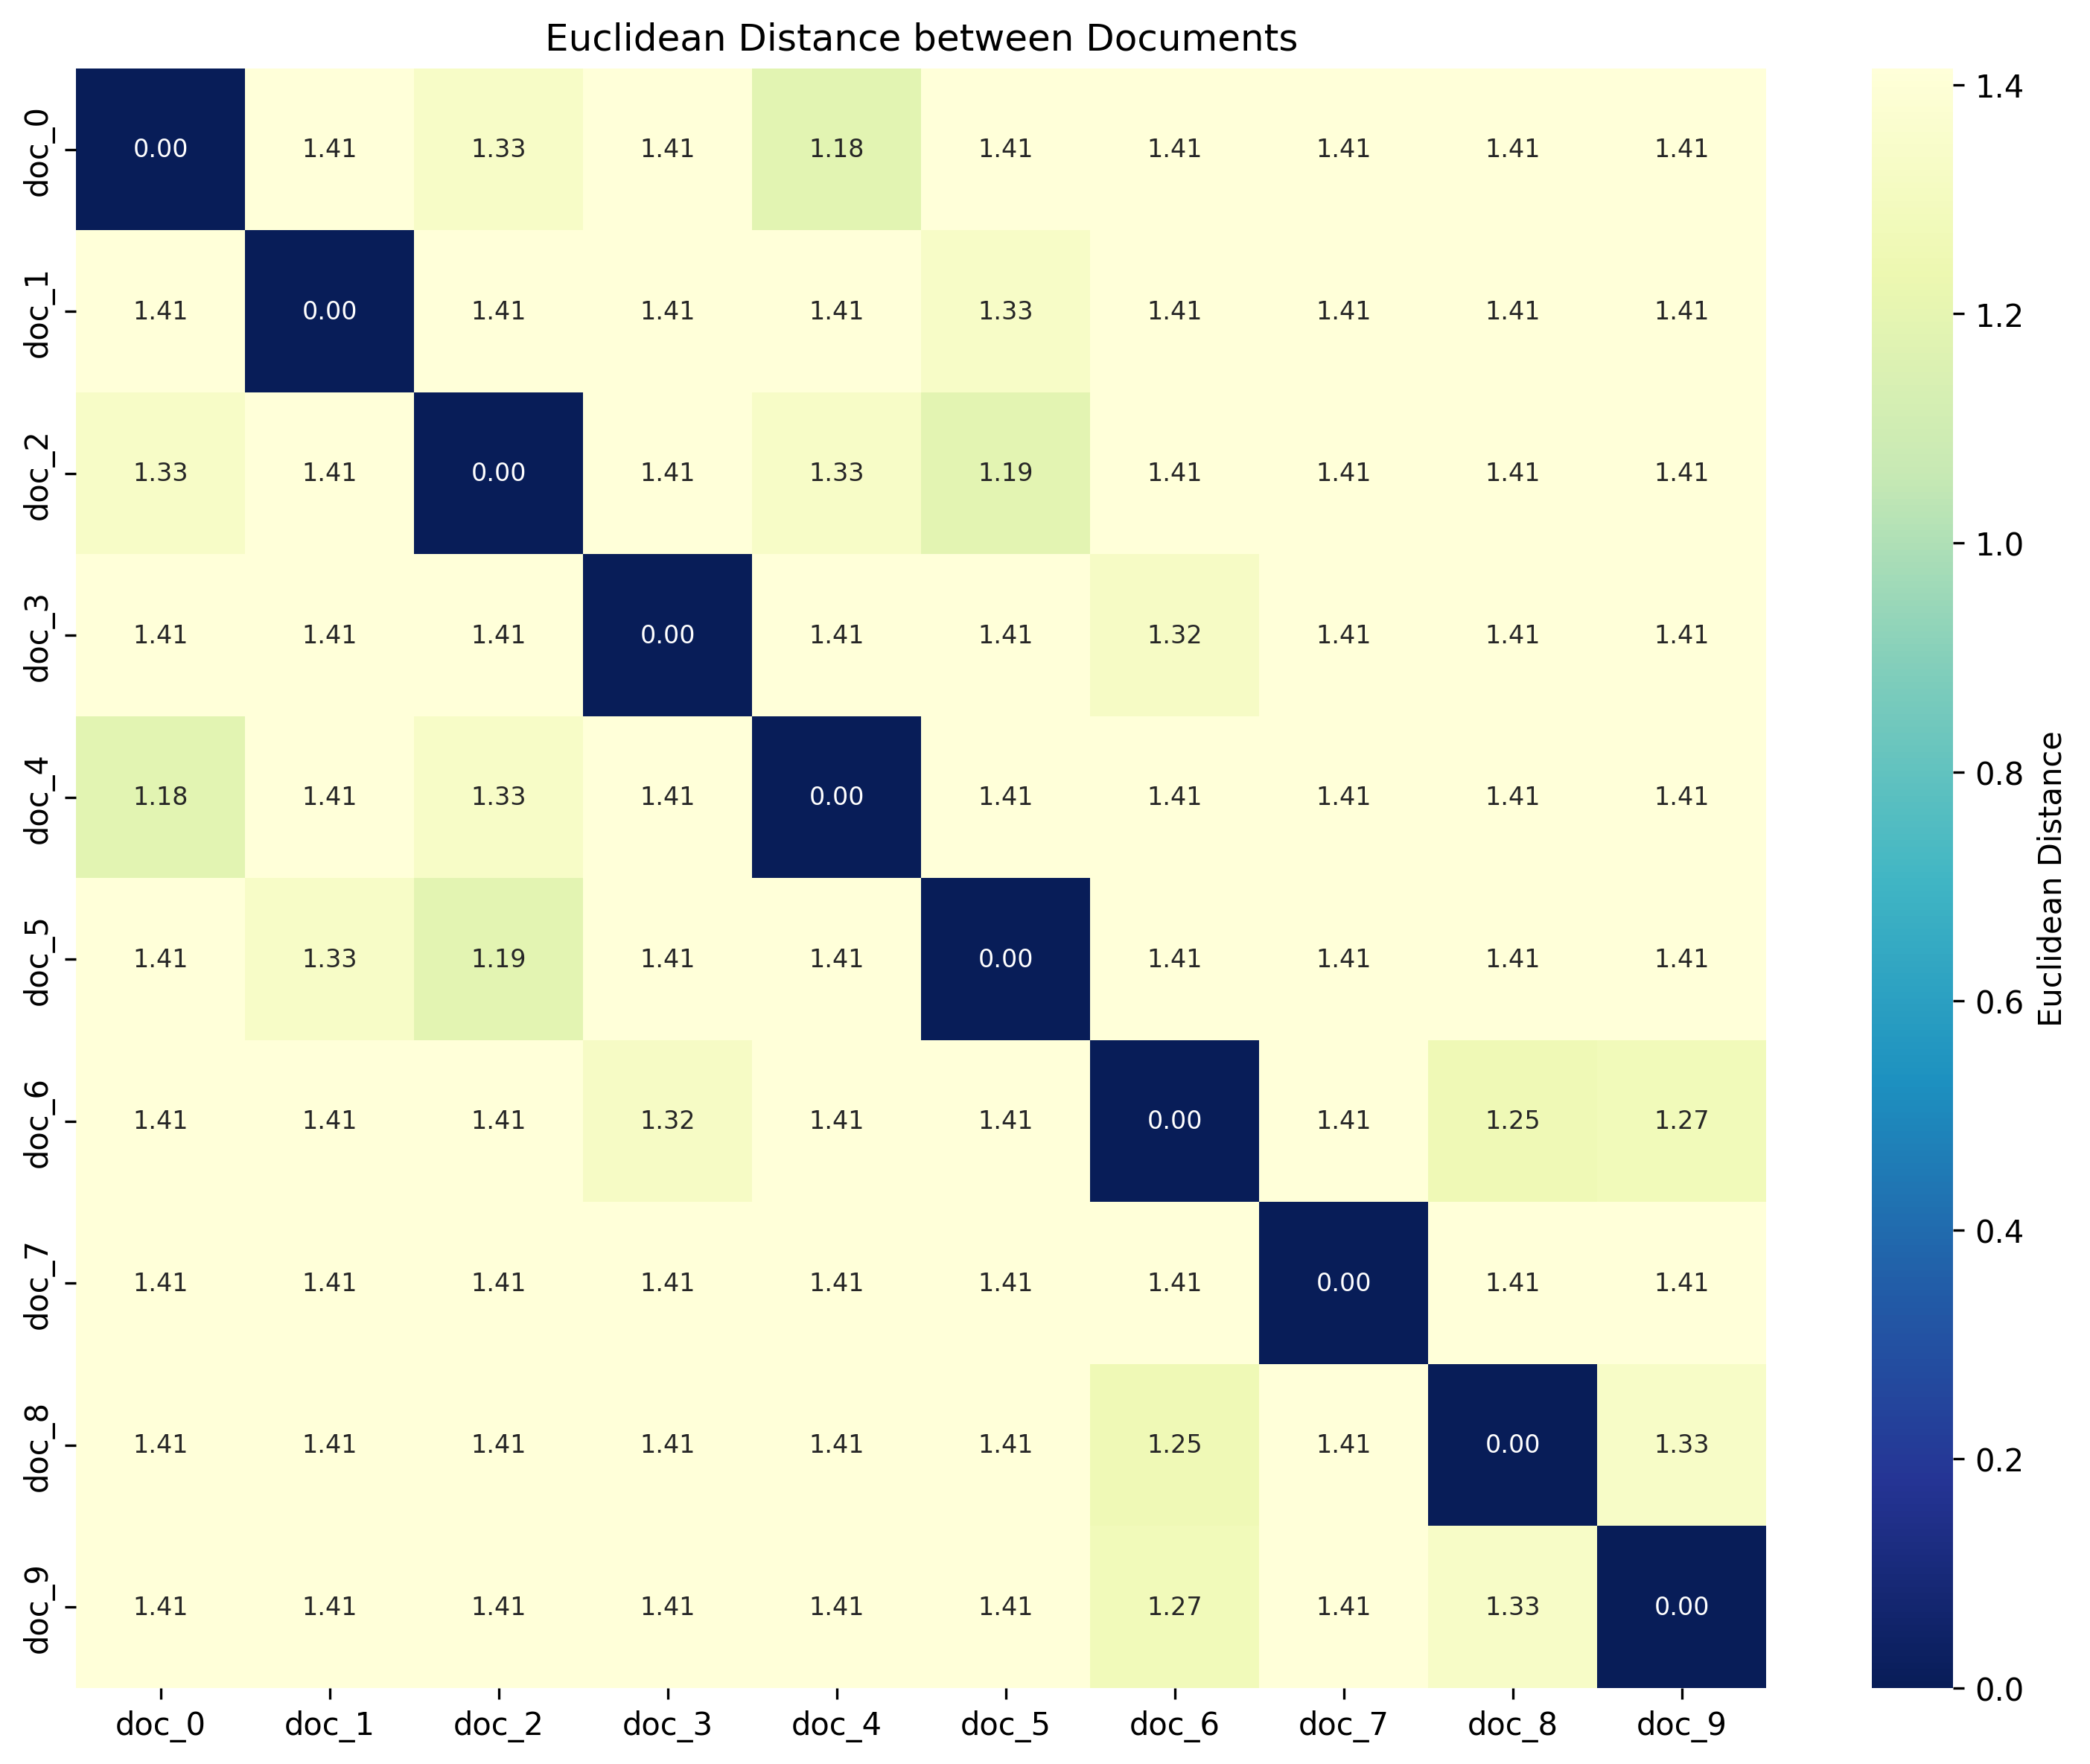

In [ ]:
# Compute Euclidean distance between documents
euclidean_dist = euclidean_distances(X_tfidf)

# Create a DataFrame for better visualization
euclidean_dist_df = pd.DataFrame(euclidean_dist, index=doc_ids, columns=doc_ids)

print("Euclidean Distance Matrix:")
display(euclidean_dist_df)

# Visualize the Euclidean distance matrix as a heatmap
plt.figure(figsize=(10, 8),dpi=300)
sns.heatmap(euclidean_dist_df, annot=True, cmap="YlGnBu_r",
            annot_kws={"size": 8}, fmt=".2f", cbar_kws={'label': 'Euclidean Distance'})
plt.title("Euclidean Distance between Documents")
plt.tight_layout()
plt.show()

### Comparing Similarity Metrics

Let's compare cosine similarity and Euclidean distance:

In [ ]:
# Convert Euclidean distance to similarity (inverse of distance)
# First normalize to [0, 1] range
max_dist = np.max(euclidean_dist)
euclidean_sim = 1 - (euclidean_dist / max_dist)

# Function to find most similar documents for a given query document
def find_most_similar(query_doc_id, similarity_matrix, top_n=3):
    """
    Find the most similar documents to a query document.

    Args:
        query_doc_id: The query document ID
        similarity_matrix: The similarity matrix
        top_n: Number of similar documents to return

    Returns:
        List of (doc_id, similarity_score) tuples
    """
    query_idx = doc_ids.index(query_doc_id)
    similarities = similarity_matrix[query_idx]

    # Create (doc_id, similarity) pairs
    doc_sim_pairs = [(doc_id, sim) for doc_id, sim in zip(doc_ids, similarities) if doc_id != query_doc_id]

    # Sort by similarity (descending)
    doc_sim_pairs.sort(key=lambda x: x[1], reverse=True)

    return doc_sim_pairs[:top_n]

# Compare top similar documents using different metrics
query_doc = "doc_0"  # "Machine learning is a subset of artificial intelligence"

print(f"Query document: {query_doc}: \"{corpus[query_doc]}\"")

print("\nTop 2 similar documents using Cosine Similarity:")
top_cosine = find_most_similar(query_doc, cosine_sim)
for doc_id, sim in top_cosine:
    print(f"{doc_id}: \"{corpus[doc_id]}\" (similarity: {sim:.4f})")

print("\nTop 2 similar documents using Euclidean Similarity:")
top_euclidean = find_most_similar(query_doc, euclidean_sim)
for doc_id, sim in top_euclidean:
    print(f"{doc_id}: \"{corpus[doc_id]}\" (similarity: {sim:.4f})")

Query document: doc_0: "Machine learning is a subset of artificial intelligence"

Top 2 similar documents using Cosine Similarity:
doc_4: "Machine learning algorithms learn from data" (similarity: 0.2984)
doc_2: "Deep learning uses neural networks with many layers" (similarity: 0.1092)
doc_1: "Natural language processing deals with interactions between computers and human language" (similarity: 0.0000)

Top 2 similar documents using Euclidean Similarity:
doc_4: "Machine learning algorithms learn from data" (similarity: 0.1624)
doc_2: "Deep learning uses neural networks with many layers" (similarity: 0.0562)
doc_6: "Vector space models represent documents as vectors" (similarity: 0.0000)


Now, let's build a simple information retrieval system that can take a query and return the most relevant documents.

In [ ]:
class SimpleIRSystem:
    def __init__(self, corpus, vectorizer_type='tfidf'):
        """
        Initialize the IR system.

        Args:
            corpus: Dictionary of document IDs and their content
            vectorizer_type: Type of vectorizer to use ('tfidf' or 'count')
        """
        self.corpus = corpus
        self.preprocessed_corpus = {doc_id: preprocess_text(text) for doc_id, text in corpus.items()}
        self.doc_ids = list(corpus.keys())

        # Select vectorizer
        if vectorizer_type == 'tfidf':
            self.vectorizer = TfidfVectorizer()
        else:
            self.vectorizer = CountVectorizer()

        # Fit the vectorizer and transform the corpus
        self.X = self.vectorizer.fit_transform([self.preprocessed_corpus[doc_id] for doc_id in self.doc_ids])

        # Get feature names
        self.feature_names = self.vectorizer.get_feature_names_out()

    def search(self, query, top_n=5, metric='cosine'):
        """
        Search for documents relevant to the query.

        Args:
            query: The query string
            top_n: Number of results to return
            metric: Similarity metric to use ('cosine' or 'euclidean')

        Returns:
            List of (doc_id, content, score) tuples
        """
        # Preprocess the query
        processed_query = preprocess_text(query)

        # Transform the query
        query_vec = self.vectorizer.transform([processed_query])

        # Compute similarity
        if metric == 'cosine':
            similarities = cosine_similarity(query_vec, self.X)[0]
        else:  # euclidean
            distances = euclidean_distances(query_vec, self.X)[0]
            max_dist = np.max(distances)
            similarities = 1 - (distances / max_dist if max_dist > 0 else distances)

        # Create (doc_id, content, score) tuples
        results = [(doc_id, self.corpus[doc_id], sim)
                  for doc_id, sim in zip(self.doc_ids, similarities)]

        # Sort by similarity (descending)
        results.sort(key=lambda x: x[2], reverse=True)

        return results[:top_n]

    def explain_search(self, query, doc_id):
        """
        Explain why a document is relevant to a query.

        Args:
            query: The query string
            doc_id: The document ID to explain

        Returns:
            Explanation string
        """
        # Preprocess the query
        processed_query = preprocess_text(query)

        # Transform the query
        query_vec = self.vectorizer.transform([processed_query])

        # Get document index
        doc_idx = self.doc_ids.index(doc_id)

        # Get document vector
        doc_vec = self.X[doc_idx]

        # Calculate cosine similarity
        similarity = cosine_similarity(query_vec, doc_vec)[0][0]

        # Get query terms and their weights
        query_terms = processed_query.split()
        query_term_weights = {}
        for term in query_terms:
            if term in self.feature_names:
                term_idx = np.where(self.feature_names == term)[0][0]
                query_term_weights[term] = query_vec[0, term_idx]

        # Get matching terms
        matching_terms = []
        for term, query_weight in query_term_weights.items():
            term_idx = np.where(self.feature_names == term)[0][0]
            doc_weight = doc_vec[0, term_idx]
            if doc_weight > 0:
                matching_terms.append((term, query_weight, doc_weight, query_weight * doc_weight))

        # Sort matching terms by contribution
        matching_terms.sort(key=lambda x: x[3], reverse=True)

        # Create explanation
        explanation = f"""
        ## Search Explanation for Query: "{query}"

        ### Document: {doc_id}
        "{self.corpus[doc_id]}"

        ### Matching Terms
        The following terms from the query match with the document:

        | Term | Query Weight | Document Weight | Contribution |
        |------|-------------|----------------|-------------|
        """

        for term, q_weight, d_weight, contrib in matching_terms:
            explanation += f"| {term} | {q_weight:.4f} | {d_weight:.4f} | {contrib:.4f} |\n"

        explanation += f"""

        ### Overall Relevance
        Cosine similarity score: {similarity:.4f}

        This document is {'highly' if similarity > 0.7 else 'moderately' if similarity > 0.3 else 'slightly'} relevant to the query.
        """

        return explanation

# Initialize the IR system
ir_system = SimpleIRSystem(corpus)

# Test the system with a query
query = "machine learning algorithms"
results = ir_system.search(query, top_n=2)

print(f"Query: \"{query}\"\n")
print("Top 2 search results:")
for i, (doc_id, content, score) in enumerate(results, 1):
    print(f"{i}. {doc_id}: \"{content}\" (score: {score:.4f})")

# Explain search result
explanation = ir_system.explain_search(query, results[0][0])
display(Markdown(explanation))

Query: "machine learning algorithms"

Top 2 search results:
1. doc_4: "Machine learning algorithms learn from data" (score: 0.7296)
2. doc_0: "Machine learning is a subset of artificial intelligence" (score: 0.4090)



        ## Search Explanation for Query: "machine learning algorithms"

        ### Document: doc_4
        "Machine learning algorithms learn from data"

        ### Matching Terms
        The following terms from the query match with the document:

        | Term | Query Weight | Document Weight | Contribution |
        |------|-------------|----------------|-------------|
        | algorithm | 0.6629 | 0.4836 | 0.3206 |
| machine | 0.5635 | 0.4111 | 0.2317 |
| learning | 0.4930 | 0.3597 | 0.1773 |


        ### Overall Relevance
        Cosine similarity score: 0.7296

        This document is highly relevant to the query.
        